# Analysis of VAM data

Look at data provided to SPI-M from PHE - the old VoC list and CoG don't seem to be quite right

This file: just look at incidence for each VOC


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import scipy.optimize as op
from numpy import linalg as LA
import sklearn.gaussian_process.kernels as sklk
from tqdm import tqdm

In [2]:
df = pd.read_csv('/Volumes/COVID19_Epi_modelling/DstlDailyData/2021-05-17/20210516 VAM line list.csv')

/Users/user/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df

,finalid,variant,variant_alt_name,seq_result,mutation,vam,exposure_type,specimen_date_sk,age,sex,...,imd_decile,death_type28,date_of_death,reporting_lab,pillar,pheccode,phecname,ltlacode,ltlaname,category
0,-1588825.0,VOC-21APR-02,Lineage B.1.617.2 (India),Confirmed,NaN,VOC-21APR-02,Awaiting information,2021-05-08,4,F,...,3.0,NaN,NaN,PILLAR 2 TESTING,Pillar 2,E45000018,North West,E08000001,Bolton,VOC
1,-3239610.0,VOC-21APR-02,Lineage B.1.617.2 (India),Confirmed,NaN,VOC-21APR-02,Awaiting information,2021-05-07,44,F,...,1.0,NaN,NaN,PILLAR 2 TESTING,Pillar 2,E45000018,North West,E08000001,Bolton,VOC
2,-3298539.0,VUI-21APR-01,Lineage B.1.617.1 (India),Confirmed,NaN,VUI-21APR-01,Awaiting information,2021-05-07,35,M,...,4.0,NaN,NaN,PILLAR 2 TESTING,Pillar 2,E45000001,London,E09000011,Greenwich,VUI
3,-3306813.0,VOC-21APR-02,Lineage B.1.617.2 (India),Confirmed,NaN,VOC-21APR-02,Awaiting information,2021-05-07,31,M,...,2.0,NaN,NaN,PILLAR 2 TESTING,Pillar 2,E45000001,London,E09000007,Camden,VOC
4,-3307648.0,VOC-21APR-02,Lineage B.1.617.2 (India),Confirmed,NaN,VOC-21APR-02,Awaiting information,2021-05-03,40,F,...,6.0,NaN,NaN,PILLAR 2 TESTING,Pillar 2,E45000005,West Midlands,E06000019,"Herefordshire, County of",VOC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216225,1672313.0,VOC-20DEC-01,Lineage B.1.1.7 (first detected in Kent),Confirmed,NaN,VOC-20DEC-01,NaN,2021-04-12,27,M,...,7.0,NaN,NaN,NATIONWIDE PATHOLOGY LIMITED,Pillar 1,E45000001,London,E09000009,Ealing,VOC
216226,1674217.0,VOC-20DEC-01,Lineage B.1.1.7 (first detected in Kent),Confirmed,NaN,VOC-20DEC-01,NaN,2021-04-18,NaN,U,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOC
216227,1676433.0,VOC-20DEC-01,Lineage B.1.1.7 (first detected in Kent),Confirmed,NaN,VOC-20DEC-01,NaN,2021-04-29,NaN,U,...,NaN,NaN,NaN,PHE NORTH WEST MANCHESTER LABORATORY,Pillar 1,NaN,NaN,NaN,NaN,VOC
216228,1677519.0,VOC-20DEC-01,Lineage B.1.1.7 (first detected in Kent),Confirmed,NaN,VOC-20DEC-01,NaN,2021-05-03,6,F,...,4.0,NaN,NaN,ONCOLOGICA UK,Pillar 1,E45000001,London,E09000030,Tower Hamlets,VOC


In [4]:
df.columns

Index(['finalid', 'variant', 'variant_alt_name', 'seq_result', 'mutation',
       'vam', 'exposure_type', 'specimen_date_sk', 'age', 'sex',
       'ethnicity_final', 'imd_decile', 'death_type28', 'date_of_death',
       'reporting_lab', 'pillar', 'pheccode', 'phecname', 'ltlacode',
       'ltlaname', 'category'],
      dtype='object')

In [5]:
pd.unique(df.variant_alt_name)

array(['Lineage B.1.617.2 (India)', 'Lineage B.1.617.1 (India)',
       'E484K (non-VOC/non-VUI)', 'Lineage B.1.1.318', 'Lineage B.1.525',
       'Lineage P1 (Japan ex Brazil)', 'Lineage B.1.351 (South Africa)',
       'Lineage B.1.324.1 with E484K', 'Lineage P.2. (Brazil)',
       'Lineage B.1.617.3 (India)',
       'Lineage B.1.1.7 (first detected in Kent)',
       'Lineage B.1.1.7 with E484K (Bristol focus)',
       'Lineage A.23.1 with E484K (Liverpool focus)',
       'Lineage P3 (Philippines)'], dtype=object)

In [6]:
dfg = df.groupby('variant_alt_name')

In [7]:
def todays(x):
    return np.array((pd.to_datetime(x['specimen_date_sk'], format='%Y-%m-%d') - pd.Timestamp("2021-01-01")) // pd.Timedelta('1D'))

In [8]:
lint = dfg.apply(todays)
lint

variant_alt_name
E484K (non-VOC/non-VUI)                        [121, 124, 125, 125, 127, 127, 127, 76, -24, -...
Lineage A.23.1 with E484K (Liverpool focus)    [-5.0, 9.0, 22.0, 22.0, 8.0, 3.0, 8.0, 8.0, 10...
Lineage B.1.1.318                              [124, 124, 127, 23, 24, 24, 30, 41, 49, 50, 50...
Lineage B.1.1.7 (first detected in Kent)       [-44, -45, 41, 50, -45, -45, -45, -44, -45, -4...
Lineage B.1.1.7 with E484K (Bristol focus)     [-14.0, -15.0, -2.0, 14.0, 2.0, 3.0, 3.0, 7.0,...
Lineage B.1.324.1 with E484K                                                              [7, 7]
Lineage B.1.351 (South Africa)                 [126.0, 127.0, 126.0, 40.0, 42.0, 58.0, 54.0, ...
Lineage B.1.525                                [126.0, 126.0, 125.0, 125.0, 14.0, 32.0, 44.0,...
Lineage B.1.617.1 (India)                      [126.0, 128.0, 122.0, nan, 110.0, 56.0, 56.0, ...
Lineage B.1.617.2 (India)                      [127.0, 126.0, 126.0, 122.0, 127.0, 126.0, 123...
Lineage B.1.6

In [9]:
lq = len(lint.index)
linnames = lint.index.values
tarr = lint.values

In [10]:
def t2inc(z):
    u = z[~np.isnan(z)]
    tt = np.arange(np.min(u),125) #np.max(u)+1)
    n = len(tt)
    yy = np.zeros(n)
    for i, t in enumerate(tt):
        yy[i] = np.sum(u==t)
    return yy, tt

In [11]:
t2inc(tarr[6])

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,  0.,  2.,  4.,  1.,  2.,
         4.,  1.,  0.,  1.,  2.,  2.,  2.,  2.,  4.,  4.,  3.,  5.,  1.,
         3.,  5.,  2.,  2.,  6.,  2.,  1.,  1.,  6.,  7.,  4.,  6.,  4.,
         8.,  4.,  6.,  6., 10., 21.,  8.,  2.,  3.,  9.,  5.,  0.,  3.,
         8.,  4.,  5.,  5.,  0.,  1.,  4.,  0.,  3.,  1.,  4.,  1.,  2.,
         6.,  2.,  7.,  5.,  5.,  2.,  2.,  6.,  1.,  4.,  0.,  3.,  0.,
         8.,  2.,  3.,  7.,  2.,  3.,  4.,  2.,  8.,  5., 14.,  6.,  3.,
         3.,  2.,  2.,  4.,  4., 10., 11.,  8.,  8., 18.,  3.,  8., 13.,
         7., 10.,  5., 15.,  7., 12., 15.,  6.,  3.,  6.,  7., 10.,  9.,
         7.,  7., 10.,  9.,  8.,  6.,  5., 18., 15., 16.,  1.,  9., 11.,
        10.,  4., 15.,  5., 10., 13.,  9.,  6.,  6., 10.,  5.,  9.,  9.,
         9.,  7.,  4.,  6.,  8.,  2.,  4.,  3.,  3.]),
 array([-27., -26., -25., -24., -23., -22., -21., -20., -19., -18., -17.,
        -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7., 

In [12]:
def mynll(x,tt,yy,alpha=1e-6):
    
    lmu = x[0:n]
    lell = x[n]
    lsig = x[n+1]
    lod = x[n+2]
    
    od = np.exp(lod)*np.ones(n)
    p = 1/od
    r = np.exp(lmu)/(od-1)
    l1 = -np.sum(st.nbinom.logpmf(yy,r,p))
    
    kern = sklk.WhiteKernel(noise_level=alpha) + (np.exp(lsig)**2)*sklk.RBF(length_scale=np.exp(lell))
    Kmat = kern(X=np.atleast_2d(tt).T)
    l2 = -st.multivariate_normal.logpdf(np.exp(lmu), mean=np.zeros(n), cov=Kmat, allow_singular=True)
    
    return l1 + l2

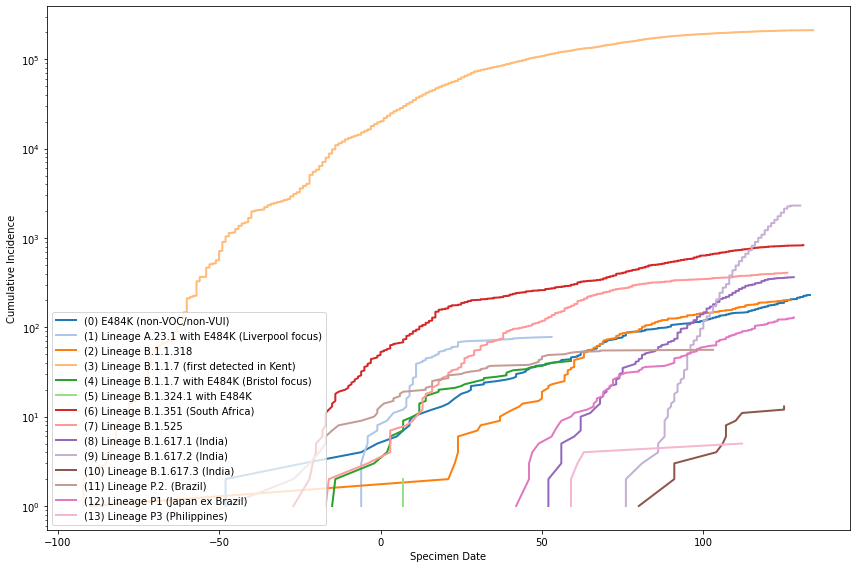

In [13]:
# Have a look to decide which ones are worth looking at
cmp = plt.cm.get_cmap('tab20')
plt.figure(figsize=(12,8))
for i in range(0,lq):
    x = lint[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label='(' + str(i) + ') ' + lint.index[i], lw=2, c=cmp(i))
plt.legend()
plt.xlabel('Specimen Date')
plt.ylabel('Cumulative Incidence')
plt.yscale('log')
plt.tight_layout()

In [14]:
ii = np.array([0, 6, 8, 9, 12])

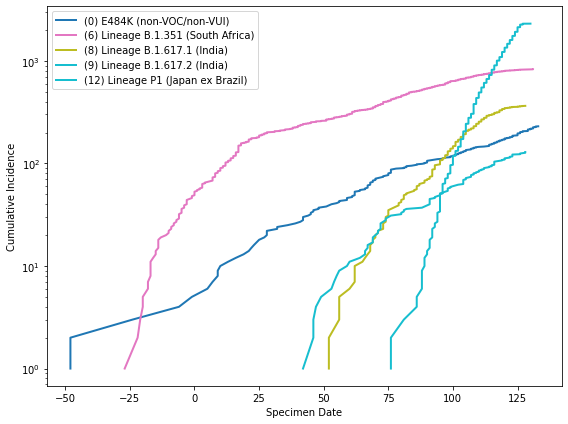

In [15]:
# Have a look to decide which ones are worth looking at
cmp = plt.cm.get_cmap('tab10')
plt.figure(figsize=(8,6))
for i in ii:
    x = lint[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label='(' + str(i) + ') ' + lint.index[i], lw=2, c=cmp(i))
plt.legend()
plt.xlabel('Specimen Date')
plt.ylabel('Cumulative Incidence')
plt.yscale('log')
plt.tight_layout()

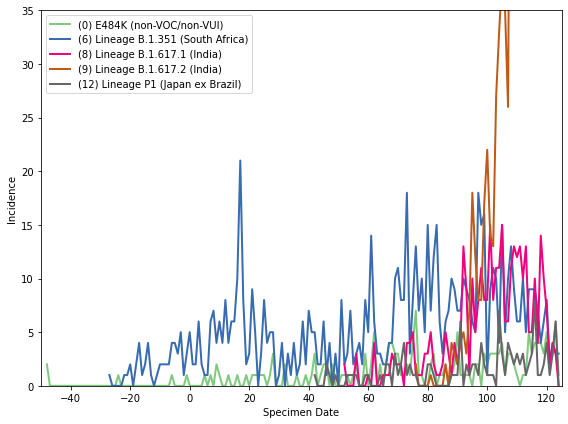

In [16]:
# Have a look to decide which ones are worth looking at
cmp = plt.cm.get_cmap('Accent',12)
plt.figure(figsize=(8,6))
for i in ii:
    yy, tt = t2inc(lint[i])
    plt.plot(tt,yy,label='(' + str(i) + ') ' + lint.index[i], lw=2, c=cmp(i))
plt.legend()
plt.xlabel('Specimen Date')
plt.ylabel('Incidence')
plt.xlim([-50,125])
plt.ylim([0,35])
plt.tight_layout()

In [17]:
lell = np.log(1.)
lsig = np.log(100.)
lod = np.log(1.5)
n = len(tt)
x0 = np.concatenate([np.log((yy+1)),[lell,lsig,lod]]) # 2.*np.ones(n)
bb = np.concatenate([np.stack([-5*np.ones(n),5*np.ones(n)]).T,np.array([[-5,5],[-5,5],[0.1,10.]])])

In [18]:
mynll(x0,tt,yy)

540.3011001348425

In [19]:
myf = lambda x : mynll(x,tt,yy)
fout = op.minimize(myf,x0,method='L-BFGS-B',bounds=bb,options={'maxfun':1000000})
fout

      fun: -340.5059499973952
 hess_inv: <86x86 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.34925244e+00,  1.03266302e+00,  1.15380771e-01, -9.48205065e-02,
       -5.83781909e-03,  7.83359151e-01,  1.23032464e+00, -7.84820027e-01,
        2.40083863e-01,  9.24853789e-01,  4.24472544e-01, -3.33420758e-01,
        2.19336016e-01, -1.40114480e+00, -7.82597454e-01, -7.32273975e-01,
       -1.80438065e-01, -2.07819539e-02,  7.64543984e-02,  7.04858394e-02,
       -1.55504267e+00, -1.06814468e+00, -2.35354492e-01, -7.46382512e-01,
        5.94582162e-02,  8.38679171e-01,  3.89536581e-01,  6.82075552e-01,
        4.10977919e-01,  7.68579866e-02, -5.38199174e-01,  1.14644649e+00,
        1.14955583e+00,  1.55290536e+00, -8.83710527e-01, -9.22517530e-01,
       -2.33853825e-01,  4.08147116e-01, -1.93404048e-01, -3.02986791e-01,
       -3.48569529e-01, -3.21733751e-01, -2.84046564e-01, -4.00223144e-01,
       -4.65752237e-01, -2.54158295e-01, -2.74695822e-01, -4.44049420e-01,
 

In [20]:
xhats = fout.x
theta = np.exp(xhats)
odhat = theta[n+2]
od = odhat*np.ones(n)
p = 1/od
r = theta[0:n]/(od-1)
ellhat = theta[n]
sighat = theta[n+1]
[ellhat, sighat, odhat]

[148.4131591025766, 2.189588513985914, 1.3014730504563388]

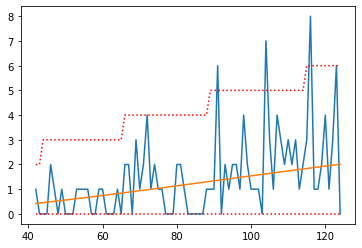

In [21]:
plt.plot(tt,yy)
plt.plot(tt,theta[0:n])
plt.plot(tt,st.nbinom.ppf(0.025,r[0:n],p[0:n]),linestyle=':',c='r')
plt.plot(tt,st.nbinom.ppf(0.975,r[0:n],p[0:n]),linestyle=':',c='r')

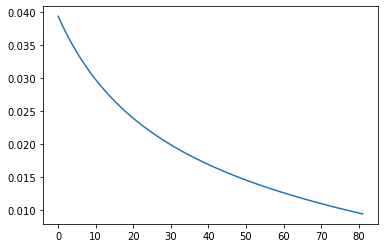

In [22]:
rr = np.diff(xhats[0:n])
plt.plot(rr)

In [23]:
def myboot(x):
    return np.random.choice(x, size=x.shape, replace=True)

In [24]:
m = 100 # Number of bootstrap samples to take

In [25]:
xhb = np.zeros((m,len(x0)))
yb = np.zeros((m,n))
for j in tqdm(range(0,m)):
    tb = myboot(lint[i])
    yyb, tau = t2inc(tb)
    q = int(tau[0]-tt[0])
    yb[j,q:(q+len(tau))] = yyb
    myf = lambda x : mynll(x,tt,yb[j,:])
    foutb = op.minimize(myf,xhats,method='L-BFGS-B',bounds=bb,options={'maxfun':1000000})
    xhb[j,:] = foutb.x

100%|██████████| 100/100 [15:19<00:00,  9.20s/it]


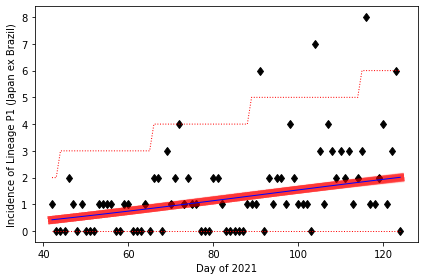

In [26]:
plt.figure(figsize=(6,4))
plt.xlabel('Day of 2021')
plt.ylabel('Incidence of ' + lint.index[i])
plt.plot(tt,yy,ls='',marker='d',c='k')
for j in range(0,m):
    plt.plot(tt,np.exp(xhb[j,0:n]),c='r',alpha=0.01,lw=8)
plt.plot(tt,theta[0:n],c='b',lw=1)
plt.plot(tt,st.nbinom.ppf(0.025,r[0:n],p[0:n]),linestyle=':',c='r',lw=1)
plt.plot(tt,st.nbinom.ppf(0.975,r[0:n],p[0:n]),linestyle=':',c='r',lw=1)
plt.tight_layout()
#plt.savefig('./figures/vam_b1617_lo.pdf')

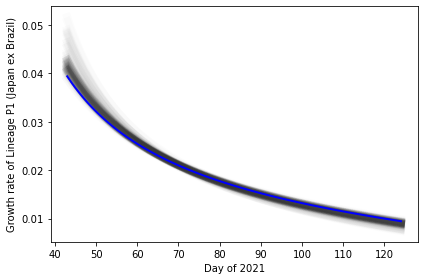

In [27]:
plt.figure(figsize=(6,4))
plt.xlabel('Day of 2021')
plt.ylabel('Growth rate of ' + lint.index[i])
for j in range(0,m):
    plt.plot(tt[1:],np.diff(xhb[j,0:n]),c='k',alpha=0.01,lw=8)
plt.plot(tt[1:],np.diff(xhats[0:n]),c='b',alpha=1,lw=2)
plt.tight_layout()

In [28]:
foutstore = []
for i in tqdm(ii):
    yy, tt = t2inc(lint[i])
    lell = np.log(1.)
    lsig = np.log(100.)
    lod = np.log(1.5)
    n = len(tt)
    x0 = np.concatenate([np.zeros(n),[lell,lsig,lod]]) # 2.*np.ones(n)
    bb = np.concatenate([np.stack([-5*np.ones(n),5*np.ones(n)]).T,np.array([[-5,5],[-5,5],[0.1,10.]])])
    
    myf = lambda x : mynll(x,tt,yy)
    fout = op.minimize(myf,x0,method='L-BFGS-B',bounds=bb,options={'maxfun':1000000})
    
    foutstore.append(fout)

100%|██████████| 5/5 [1:03:35<00:00, 763.14s/it] 


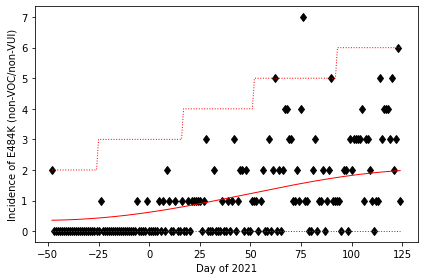

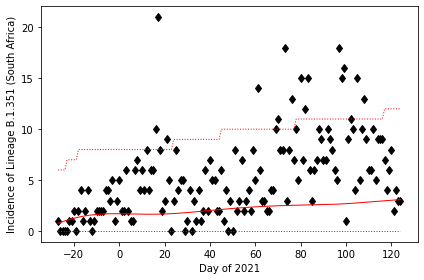

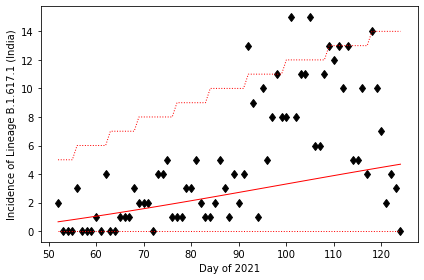

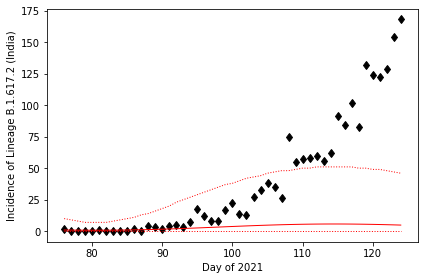

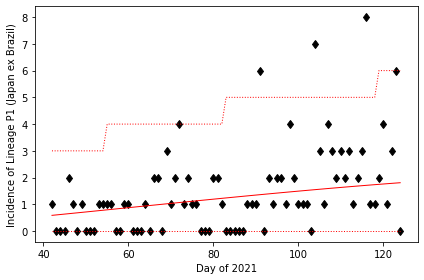

In [29]:
for j, i in enumerate(ii):
    yy, tt = t2inc(lint[i])
    n = len(tt)
    xhats = foutstore[j].x
    plt.figure(figsize=(6,4))
    plt.xlabel('Day of 2021')
    plt.ylabel('Incidence of ' + lint.index[i])
    plt.plot(tt,yy,ls='',marker='d',c='k') 
    theta = np.exp(xhats)
    odhat = theta[n+2]
    od = odhat*np.ones(n)
    p = 1/od
    r = theta[0:n]/(od-1)
    plt.plot(tt,theta[0:n],c='r',lw=1)  
    plt.plot(tt,st.nbinom.ppf(0.025,r[0:n],p[0:n]),linestyle=':',c='r',lw=1)
    plt.plot(tt,st.nbinom.ppf(0.975,r[0:n],p[0:n]),linestyle=':',c='r',lw=1)
    plt.tight_layout()

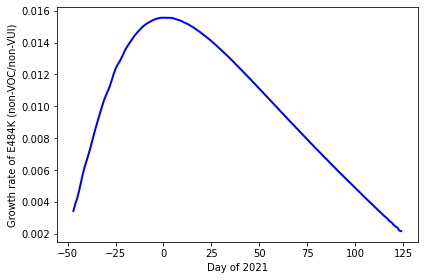

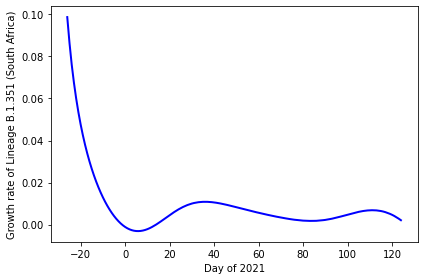

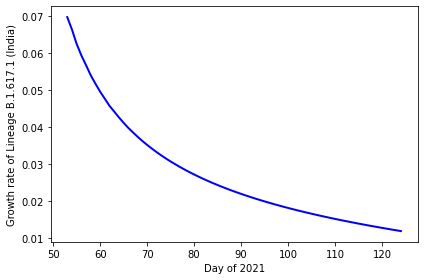

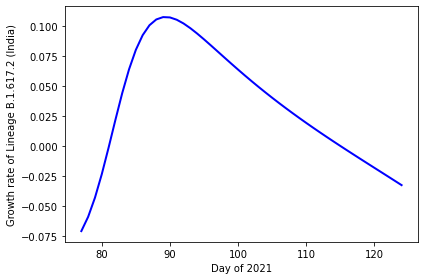

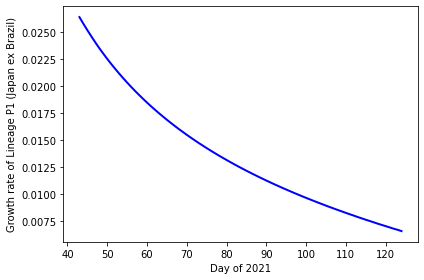

In [30]:
for j, i in enumerate(ii):
    yy, tt = t2inc(lint[i])
    n = len(tt)
    xhats = foutstore[j].x
    plt.figure(figsize=(6,4))
    plt.xlabel('Day of 2021')
    plt.ylabel('Growth rate of ' + lint.index[i])
    plt.plot(tt[1:],np.diff(xhats[0:n]),c='b',alpha=1,lw=2)
    plt.tight_layout()